# King County House Sales Price Prediction

![image](https://storage.googleapis.com/kaggle-datasets-images/128/270/d149695d1f9a97ec54cf673be6430ad7/dataset-cover.jpg)

## Summary

* [1. Required Libraries](#1)
* [2. Visualizing and Examining Data](#2)
* [3. Predicting House Prices](#3)

### <span id="1"></span> 1. Required Libraries

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import pygad
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import DBSCAN
import statsmodels.api as sm
import random

import warnings
warnings.filterwarnings("ignore")

seed = 99
random.seed(seed)
np.random.seed(seed)

n_jobs = 15 # number of jobs for parallel tasks

df = pd.read_csv("kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [3]:
df.shape

(21613, 21)

In [4]:
df.drop(["id"], axis=1, inplace=True) # remove unused feature
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d", exact=False) # transform date column to datetime format
df.drop_duplicates(inplace=True, keep="first") # remove duplicated rows

In [5]:
def check_columns(df):
    for col in df.columns:

        print(f"{col}:")
        if df[col].nunique() >= 10:
            print(f"[{df[col].min()} ... {df[col].max()}]")
        else:
            print(df[col].unique())

check_columns(df)

date:
[2014-05-02 00:00:00 ... 2015-05-27 00:00:00]
price:
[75000.0 ... 7700000.0]
bedrooms:
[0 ... 33]
bathrooms:
[0.0 ... 8.0]
sqft_living:
[290 ... 13540]
sqft_lot:
[520 ... 1651359]
floors:
[1.  2.  1.5 3.  2.5 3.5]
waterfront:
[0 1]
view:
[0 3 4 2 1]
condition:
[3 5 4 1 2]
grade:
[1 ... 13]
sqft_above:
[290 ... 9410]
sqft_basement:
[0 ... 4820]
yr_built:
[1900 ... 2015]
yr_renovated:
[0 ... 2015]
zipcode:
[98001 ... 98199]
lat:
[47.1559 ... 47.7776]
long:
[-122.519 ... -121.315]
sqft_living15:
[399 ... 6210]
sqft_lot15:
[651 ... 871200]


### <span id="2"></span> 2. Visualizing and Examining Data

In [6]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Since we don't have many features, we will start plotting histograms for each column, so we can get to know their distribution and values.

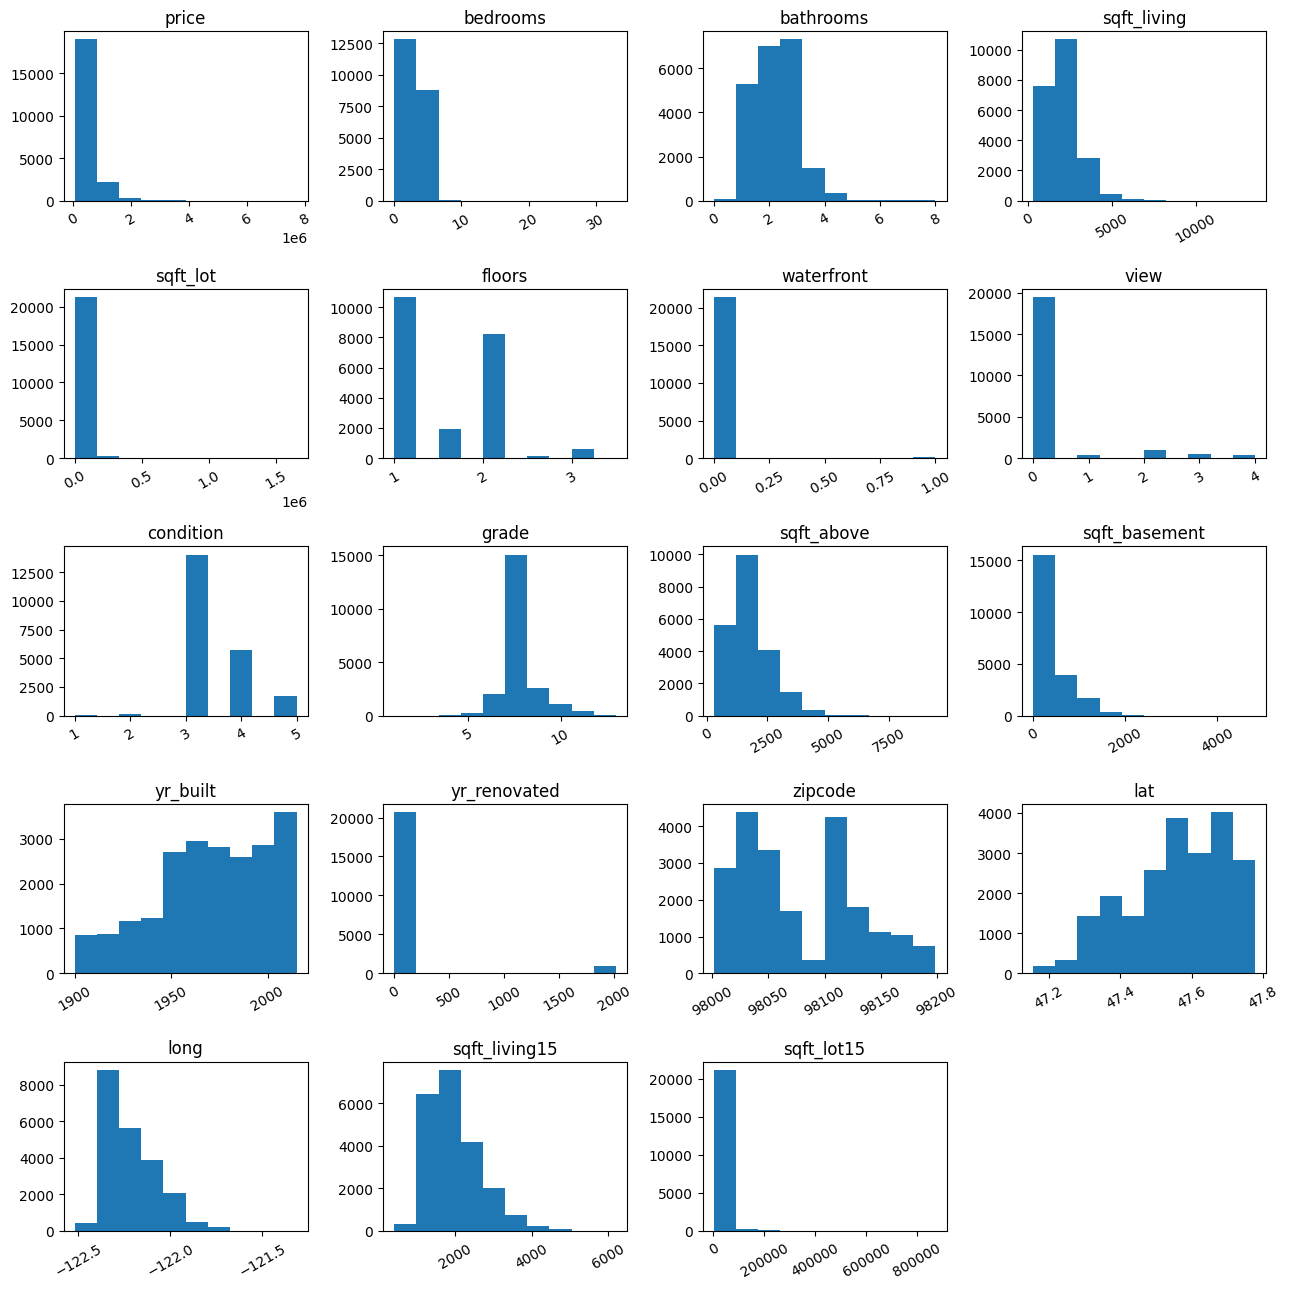

In [7]:
plot_features = df.drop("date", axis=1).columns.values
n_cols = 4
n_rows = math.ceil(len(plot_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, 13))
for idx, feature in enumerate(plot_features):
    ax = axes[int(idx / 4)][idx % 4]
    ax.set_title(feature)
    ax.hist(df[feature])

    for label in ax.get_xticklabels():
        label.set_rotation(30)

idx += 1
while idx < (n_rows * n_cols):
    ax = axes[int(idx / 4)][idx % 4]
    fig.delaxes(ax)
    idx += 1

plt.tight_layout()
plt.show()

Some features are highly skewed, indicating a possible presence of **outliers** in our dataset.

Now, let's try to identify the relationships between the dependent variable (price) and the independent ones.

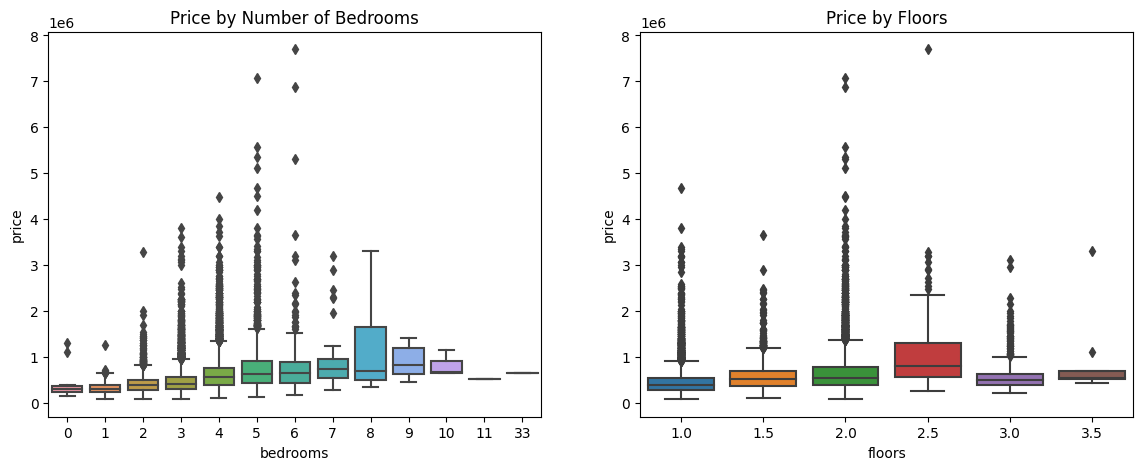

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.set_title("Price by Number of Bedrooms")
sns.boxplot(
    data=df,
    x="bedrooms",
    y="price",
    ax=ax
)

ax = axes[1]
ax.set_title("Price by Floors")
sns.boxplot(
    data=df,
    x="floors",
    y="price",
    ax=ax
)

fig.show()

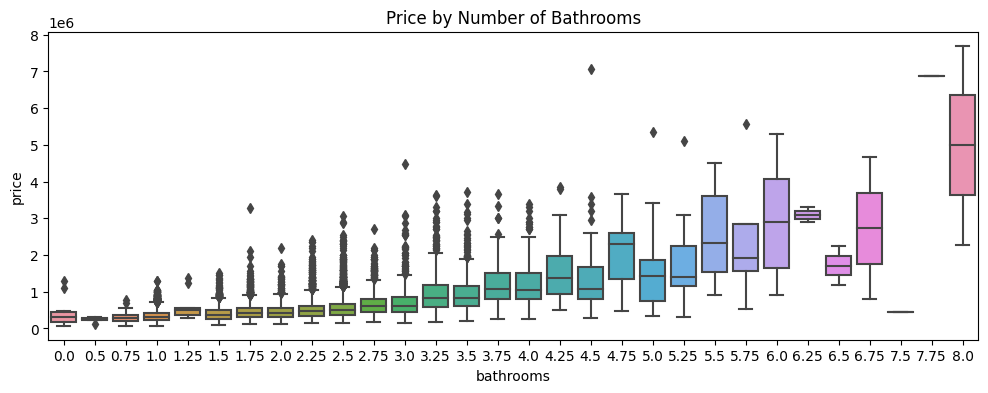

In [9]:
plt.figure(figsize=(12, 4))
plt.title("Price by Number of Bathrooms")
sns.boxplot(
    data=df,
    x="bathrooms",
    y="price"
)
plt.show()

From the **boxplots** above, we cannot see any clear linear relationship between the number of bedrooms, bathrooms and floors and the houses prices.

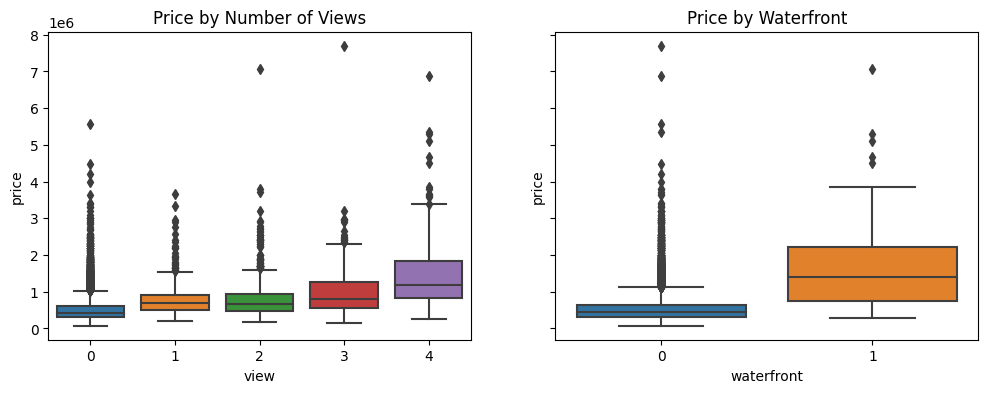

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax = axes[0]
ax.set_title("Price by Number of Views")
sns.boxplot(
    data=df,
    x="view",
    y="price",
    ax=ax
)

ax = axes[1]
ax.set_title("Price by Waterfront")
sns.boxplot(
    data=df,
    x="waterfront",
    y="price",
    ax=ax
)

fig.show()

By the graphs above, we can see that the view and waterfront variables don't have a direct impact to the price variable. Therefore, waterfront houses have higher average prices.

We have two columns in the dataset that indicates the _latitude_ and _longitude_ of the houses locations. So we will draw a map that can be useful for people that know the area well.

In [11]:
fig = px.density_mapbox(
    df,
    lat="lat",
    lon="long",
    z="price",
    radius=10,
    zoom=7,
    opacity=.6,
    mapbox_style="stamen-terrain",
    width=900,
    height=500
)

fig.show()

## <span id="3"></span>3. Predicting House Prices

In this section, we will build machine learning models to predict the prices of houses in King County.
Let's begin with some function definitions for model evaluation.

In [12]:
def plot_residuals(y_true, y_pred):
    residuals = y_pred - y_true
    plt.figure(figsize=(6, 4))
    plt.title("Residual Plot")
    plt.scatter(np.arange(len(residuals)), residuals)
    plt.axhline(0, linestyle="--", color="red")
    plt.xlabel("predictions")
    plt.ylabel("residuals")
    max_resid = np.abs(residuals).max()
    plt.ylim((-1 * (max_resid + 1), (max_resid + 1)))
    plt.show()

def metrics(y_true, y_pred):
    r2 = np.round(r2_score(y_true, y_pred), 2)
    mse = np.round(mean_squared_error(y_true, y_pred), 2)
    rmse = np.round(np.sqrt(mse), 2)
    mae = np.round(mean_absolute_error(y_true, y_pred), 2)

    return pd.DataFrame(data={
        "R^2": [r2],
        "RMSE": [rmse],
        "MSE": [mse],
        "MAE": [mae]
    })

### <span id="3-1"></span> 3.1 Data Preprocessing

In [13]:
X = df.drop(["date", "price"], axis=1).values
y = df["price"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(15129, 18)
(6484, 18)


In [14]:
model = LinearRegression()

model.fit(X_train, y_train)
y_preds = model.predict(X_test)

metrics(y_test, y_preds)

,R^2,RMSE,MSE,MAE
0,0.69,205379.94,4.218092e+10,128890.26


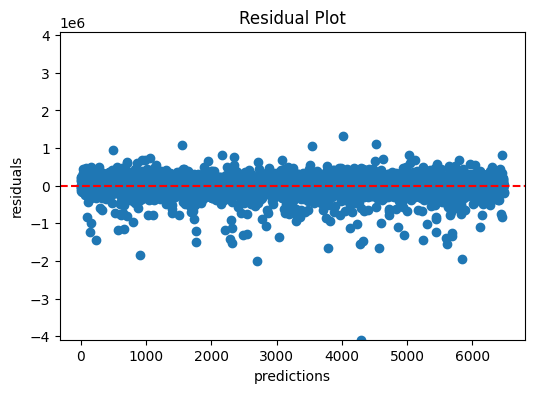

In [15]:
plot_residuals(y_test, y_preds)

In [16]:
model = make_pipeline(
    PolynomialFeatures(2),
    LinearRegression()
)

model.fit(X_train, y_train)
y_preds = model.predict(X_test)

metrics(y_test, y_preds)

,R^2,RMSE,MSE,MAE
0,0.81,161213.44,2.598977e+10,102682.63


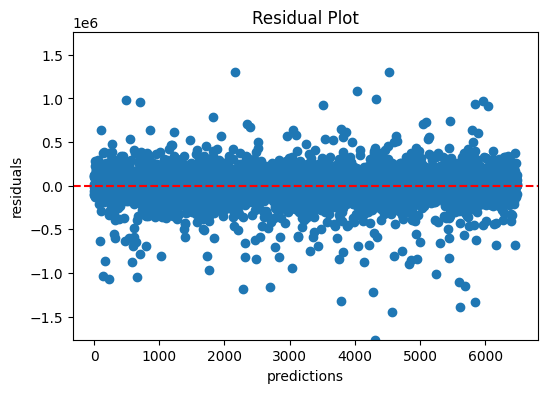

In [17]:
plot_residuals(y_test, y_preds)

In [18]:
model = make_pipeline(
    PolynomialFeatures(2),
    MinMaxScaler(),
    LinearRegression()
)

model.fit(X_train, y_train)
y_preds = model.predict(X_test)

metrics(y_test, y_preds)

,R^2,RMSE,MSE,MAE
0,0.81,161246.48,2.600043e+10,102691.04


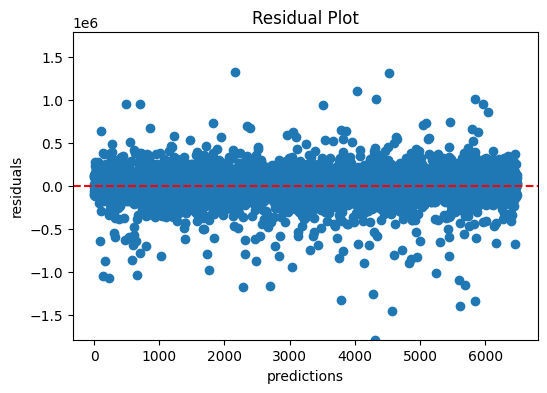

In [19]:
plot_residuals(y_test, y_preds)

In [20]:
model = make_pipeline(
    PolynomialFeatures(2),
    StandardScaler(),
    LinearRegression()
)

model.fit(X_train, y_train)
y_preds = model.predict(X_test)

metrics(y_test, y_preds)

,R^2,RMSE,MSE,MAE
0,0.81,161316.57,2.602304e+10,102770.83


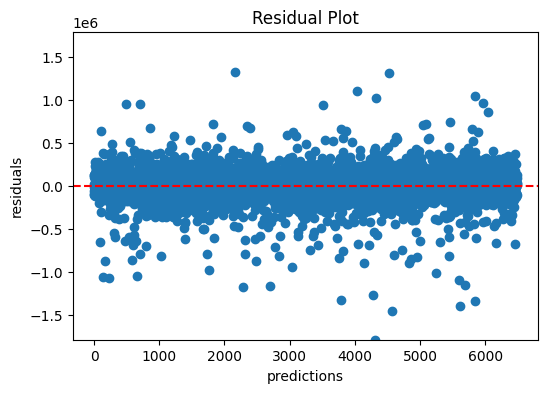

In [21]:
plot_residuals(y_test, y_preds)